# Character-Level LSTM — The Office (US)
Simple, fast, readable training on dialogue lines formatted as `PERSON: Dialogue`.


In [ ]:
import math
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed_all(42)

print("device:", device)


device: cuda


In [ ]:
# Path to the dialogue text file
# In Colab, upload the file or mount Drive and update this path if needed.
data_path = "office_script_clean.txt"

with open(data_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

# Light cleaning only: remove timestamps, HTML, stage directions, extra spaces
# Keep punctuation, newlines, ellipses.

def clean_line(line: str) -> str:
    line = re.sub(r"<[^>]+>", "", line)  # HTML tags
    line = re.sub(r"\[?\(?\d{1,2}:\d{2}(?::\d{2})?\)?\]?", "", line)  # timestamps
    line = re.sub(r"\[[^\]]*\]", "", line)  # [STAGE DIRECTIONS]
    line = re.sub(r"\(([^a-z]*)\)", "", line)  # (STAGE DIRECTIONS)
    line = re.sub(r"\s+", " ", line).strip()
    return line

lines = []
for line in raw_text.splitlines():
    line = clean_line(line)
    if ":" not in line:
        continue
    speaker, dialogue = line.split(":", 1)
    speaker = re.sub(r"\s+", " ", speaker.strip()).upper()
    dialogue = dialogue.strip()
    if not dialogue:
        continue
    lines.append(f"{speaker}: {dialogue}")

text = "\n".join(lines)
print(text[:500])


MICHAEL: All right Jim. Your quarterlies look very good. How are things at the library?
JIM: Oh, I told you. I couldn't close it. So...
MICHAEL: So you've come to the master for guidance? Is this what you're saying, grasshopper?
JIM: Actually, you called me in here, but yeah.
MICHAEL: All right. Well, let me show you how it's done.
MICHAEL: Yes, I'd like to speak to your office manager, please. Yes, hello. This is Michael Scott. I am the Regional Manager of Dunder Mifflin Paper Products. Just wa


In [ ]:
# Character vocabulary
chars = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

# Encode the entire text into one 1D tensor on the selected device
encoded = torch.tensor([stoi[ch] for ch in text], dtype=torch.long, device=device)

print("vocab size:", len(chars))
print("total characters:", encoded.numel())
print("device:", device)


vocab size: 72
total characters: 3416847
device: cuda


In [ ]:
# Train/val split (90/10 by order)
train_len = int(0.9 * encoded.numel())
train_data_1d = encoded[:train_len]
val_data_1d = encoded[train_len:]

batch_size = 256
seq_len = 256

def batchify(data_1d: torch.Tensor, batch_size: int) -> torch.Tensor:
    n_batches = data_1d.numel() // batch_size
    data_1d = data_1d[: n_batches * batch_size]
    data = data_1d.view(batch_size, -1).t().contiguous()  # [T, B]
    return data

train_data = batchify(train_data_1d, batch_size)
val_data = batchify(val_data_1d, batch_size)

print("train data shape:", train_data.shape)
print("val data shape:", val_data.shape)


train data shape: torch.Size([12012, 256])
val data shape: torch.Size([1334, 256])


In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # x: [T, B]
        emb = self.embedding(x)  # [T, B, E]
        out, hidden = self.lstm(emb, hidden)  # [T, B, H]
        out = self.dropout(out)
        logits = self.fc(out)  # [T, B, V]
        return logits, hidden

    def init_hidden(self, batch_size: int, device: torch.device):
        weight = next(self.parameters())
        h = weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c = weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h, c)

vocab_size = len(chars)
model = CharLSTM(vocab_size, embed_dim=128, hidden_size=512, num_layers=2, dropout=0.2).to(device)
print(model)


CharLSTM(
  (embedding): Embedding(72, 128)
  (lstm): LSTM(128, 512, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=72, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

use_amp = device.type == "cuda"
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def get_batch(source: torch.Tensor, i: int, seq_len: int):
    seq_len = min(seq_len, source.size(0) - 1 - i)
    x = source[i : i + seq_len]
    y = source[i + 1 : i + seq_len + 1]
    return x, y

def detach_hidden(hidden):
    return (hidden[0].detach(), hidden[1].detach())

def run_epoch(source: torch.Tensor, train: bool = True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_count = 0
    batch_size_local = source.size(1)
    hidden = model.init_hidden(batch_size_local, device)

    for i in range(0, source.size(0) - 1, seq_len):
        x, y = get_batch(source, i, seq_len)
        if x.size(0) == 0:
            break

        if train:
            optimizer.zero_grad(set_to_none=True)

        hidden = detach_hidden(hidden)

        with torch.set_grad_enabled(train):
            if use_amp:
                with torch.cuda.amp.autocast():
                    logits, hidden = model(x, hidden)
                    loss = criterion(logits.view(-1, vocab_size), y.reshape(-1))
            else:
                logits, hidden = model(x, hidden)
                loss = criterion(logits.view(-1, vocab_size), y.reshape(-1))

        if train:
            if use_amp:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        total_loss += loss.item() * y.numel()
        total_count += y.numel()

    return total_loss / total_count

epochs = 12
train_losses = []
val_losses = []
train_ppls = []
val_ppls = []

for epoch in range(1, epochs + 1):
    train_loss = run_epoch(train_data, train=True)
    val_loss = run_epoch(val_data, train=False)

    train_ppl = math.exp(train_loss)
    val_ppl = math.exp(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ppls.append(train_ppl)
    val_ppls.append(val_ppl)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {train_loss:.4f}, train ppl {train_ppl:.2f} | "
        f"val loss {val_loss:.4f}, val ppl {val_ppl:.2f}"
    )


/tmp/ipython-input-565556252.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-565556252.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01 | train loss 2.5950, train ppl 13.40 | val loss 1.9602, val ppl 7.10
Epoch 02 | train loss 1.7065, train ppl 5.51 | val loss 1.5695, val ppl 4.80
Epoch 03 | train loss 1.4704, train ppl 4.35 | val loss 1.4203, val ppl 4.14
Epoch 04 | train loss 1.3627, train ppl 3.91 | val loss 1.3475, val ppl 3.85
Epoch 05 | train loss 1.2994, train ppl 3.67 | val loss 1.3040, val ppl 3.68
Epoch 06 | train loss 1.2551, train ppl 3.51 | val loss 1.2748, val ppl 3.58
Epoch 07 | train loss 1.2229, train ppl 3.40 | val loss 1.2544, val ppl 3.51
Epoch 08 | train loss 1.1976, train ppl 3.31 | val loss 1.2391, val ppl 3.45
Epoch 09 | train loss 1.1765, train ppl 3.24 | val loss 1.2271, val ppl 3.41
Epoch 10 | train loss 1.1592, train ppl 3.19 | val loss 1.2189, val ppl 3.38
Epoch 11 | train loss 1.1451, train ppl 3.14 | val loss 1.2115, val ppl 3.36
Epoch 12 | train loss 1.1319, train ppl 3.10 | val loss 1.2103, val ppl 3.35


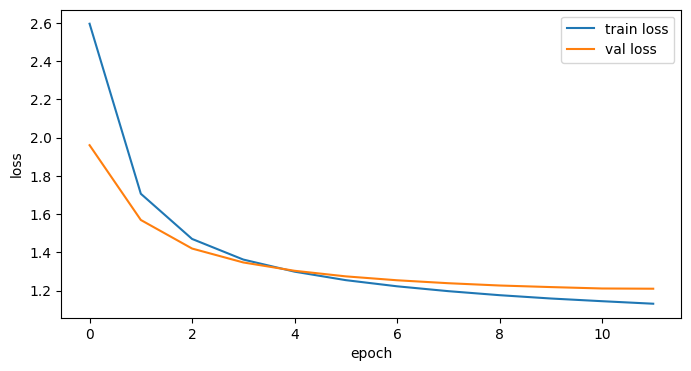

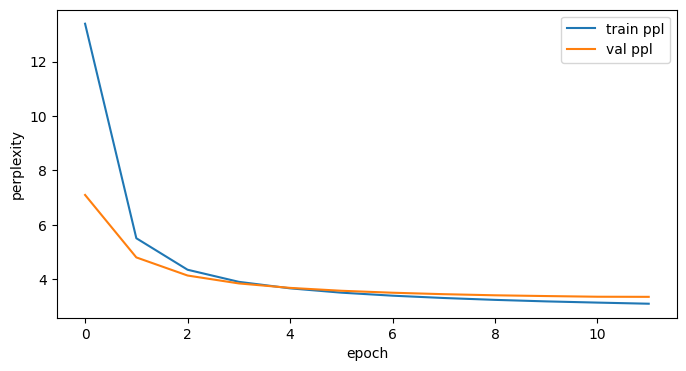

In [ ]:
# Plots
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_ppls, label="train ppl")
plt.plot(val_ppls, label="val ppl")
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.legend()
plt.show()


In [ ]:
def generate_script(seed_text: str, temperature: float, num_tokens_to_generate: int):
    model.eval()
    hidden = model.init_hidden(1, device)
    generated = seed_text

    with torch.no_grad():
        # Prime the model with the seed text
        for ch in seed_text:
            if ch not in stoi:
                continue
            x = torch.tensor([[stoi[ch]]], device=device)
            _, hidden = model(x, hidden)

        last_char = seed_text[-1] if seed_text and seed_text[-1] in stoi else " "
        x = torch.tensor([[stoi[last_char]]], device=device)

        for _ in range(num_tokens_to_generate):
            logits, hidden = model(x, hidden)
            logits = logits.squeeze(0).squeeze(0) / temperature
            probs = torch.softmax(logits, dim=0)
            idx = torch.multinomial(probs, 1).item()
            ch = itos[idx]
            generated += ch
            x = torch.tensor([[idx]], device=device)

    return generated

seed_text = "MICHAEL: "
samples = {}
for temp in [0.3, 0.7, 1.0]:
    samples[temp] = generate_script(seed_text, temperature=temp, num_tokens_to_generate=600)
    print(f"\n--- Temperature {temp} ---\n")
    print(samples[temp])



--- Temperature 0.3 ---

MICHAEL: have a commission and the best of the way to make a confusing to the same time.
MICHAEL: I don't know what the most complicated in the really sorry.
MICHAEL: I would like to talk about the same time. I think that we are really not now.
MICHAEL: Oh, you know what? I want to see this in the work because I want to be a little bit of a company to the rest of the work company to the state of the company to be a big deal. I have a big man of the way to be a good idea.
MICHAEL: I don't know what they want to be so doing a good idea.
MICHAEL: I don't know what I was thinking.
PAM: Oh, okay. I thought 

--- Temperature 0.7 ---

MICHAEL: recommended  until out of here for the party.
ANDY: Alright, but uh, see this not.
MICHAEL: No, no, no. The bathroom of shower.
JIM: Yes.
ANDY: No. I want to stop it.
ANGELA: It's just something happens. And it is not an empty deep. This will commiss up to dinner. So they're supposed to take out of the office. I am not a little

```
Final Validation Loss: 1.2103
Final Validation Perplexity: 3.3545

Seed Text: MICHAEL:
Temperature for Best Sample: 0.7

Best Generated Sample:
MICHAEL: recommended  until out of here for the party.
ANDY: Alright, but uh, see this not.
MICHAEL: No, no, no. The bathroom of shower.
JIM: Yes.
ANDY: No. I want to stop it.
ANGELA: It's just something happens. And it is not an empty deep. This will commiss up to dinner. So they're supposed to take out of the office. I am not a little bit. I feel like that thing off the boat.
MICHAEL: So you know what, I can get them out.
MICHAEL: Do her last night. The sweet guy and the one is on the time. I know why I want you to see you to the front.
DWIGHT: I'm not terrible to hear that really mad at the randon.
```

**Sampling behavior:**
- `temperature = 0.3` tends to be more repetitive and safe.
- `temperature = 0.7` is usually the best balance of coherence and variety.
- `temperature = 1.0` is more diverse but can be messy or off-topic.


In [ ]:
final_val_loss = val_losses[-1]
final_val_ppl = val_ppls[-1]

best_temp = 0.7
best_sample = samples[best_temp]

print("Final validation loss:", final_val_loss)
print("Final validation perplexity:", final_val_ppl)
print("Best generated sample:")
print(best_sample)
print("Seed text:", seed_text)
print("Temperature:", best_temp)


Final validation loss: 1.2103079006534185
Final validation perplexity: 3.3545173516409768
Best generated sample:
MICHAEL: recommended  until out of here for the party.
ANDY: Alright, but uh, see this not.
MICHAEL: No, no, no. The bathroom of shower.
JIM: Yes.
ANDY: No. I want to stop it.
ANGELA: It's just something happens. And it is not an empty deep. This will commiss up to dinner. So they're supposed to take out of the office. I am not a little bit. I feel like that thing off the boat.
MICHAEL: So you know what, I can get them out.
MICHAEL: Do her last night. The sweet guy and the one is on the time. I know why I want you to see you to the front.
DWIGHT: I'm not terrible to hear that really mad at the randon. 
Seed text: MICHAEL: 
Temperature: 0.7
